# Data wrangling with Polars
## Arturo Regalado
## APUG meetup - May 2023

In this notebook we explore the Polars API for data wrangling operations. 
We will work with the [Pokemon dataset](https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6) that ias information on over 600 Pokemon

We will focus in understanding Polars DSL for data wrangling operations based on context and expressions. 
For details refer to the Polars [user guide](https://pola-rs.github.io/polars-book/user-guide/0) and [reference.](https://pola-rs.github.io/polars/py-polars/html/reference/)

Think of context as predicates for data tasks. They refer to to scope where operations take place. This will look familiar to dplyr users from R (although it is not entirely equivalent). Main contexts:

* Selection
* Filtering
* Groupby

Expressions on the other hand are the core operations for data analysis that take place within a context. Expressions are similar to method chaining in Pandas or the pipe operator in dplyr. 

Lets work first with Polars eager API and then show how to use the Lazy API which is the preferred approach for polars. 

In [36]:
# Setup
import polars as pl 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

url = r"https://gist.githubusercontent.com/ritchie46/cac6b337ea52281aa23c049250a4ff03/raw/89a957ff3919d90e6ef2d34235e6bf22304f3366/pokemon.csv"
df = pl.read_csv(url)
df.head()

#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,bool
1,"""Bulbasaur""","""Grass""","""Poison""",318,45,49,49,65,65,45,1,false
2,"""Ivysaur""","""Grass""","""Poison""",405,60,62,63,80,80,60,1,false
3,"""Venusaur""","""Grass""","""Poison""",525,80,82,83,100,100,80,1,false
3,"""VenusaurMega V…","""Grass""","""Poison""",625,80,100,123,122,120,80,1,false
4,"""Charmander""","""Fire""",null,309,39,52,43,60,50,65,1,false


**Note to new users of python for data analysis** Remember, the library is a tool to extract information from data. It is up to the analyst to make the questions and decide what is necessary. After loading a dataset we need to squeeze the information out of it. Let's ask some questions and use polars to extract the data from the pokemon. 

Top 5 pokemon types: shape: (5, 2)
┌────────┬───────┐
│ Type 1 ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ Water  ┆ 31    │
│ Normal ┆ 24    │
│ Fire   ┆ 14    │
│ Poison ┆ 14    │
│ Bug    ┆ 14    │
└────────┴───────┘


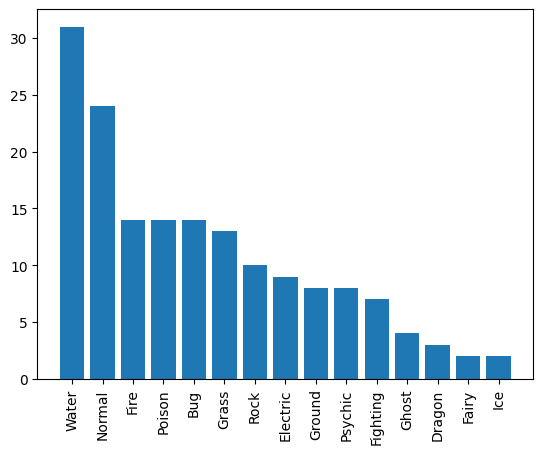

In [2]:
# How many pokemons are there by type? We see that pokemons can have two types. Let's focus on the first type. 

out = (
    df
    .groupby("Type 1")
    .agg(pl.count())
    .sort("count", descending=True)
)

print(f"Top 5 pokemon types: {out.head(5)}")
plt.bar(out["Type 1"], out["count"])
plt.xticks(rotation=90)
plt.show()

Number of double types: 28
Top 5 pokemon double types (excluding null): shape: (5, 2)
┌───────────────┬───────┐
│ Combined Type ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ Grass/Poison  ┆ 10    │
│ Normal/Flying ┆ 9     │
│ Bug/Poison    ┆ 6     │
│ Rock/Water    ┆ 4     │
│ Rock/Ground   ┆ 4     │
└───────────────┴───────┘


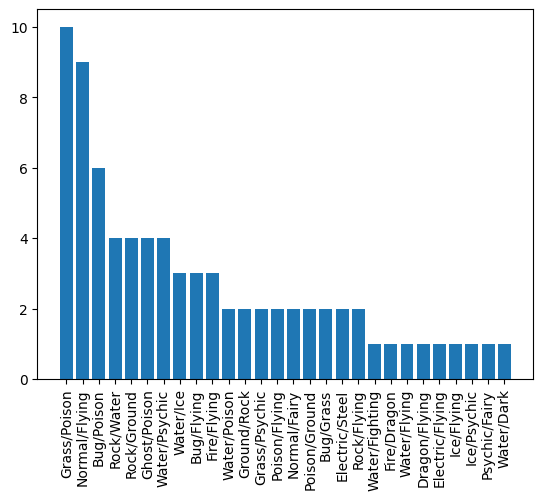

In [3]:
# It might also be useful to know how many have double types and see what is the most common combination. We can create a custom function and explore some of the string capabilities of Polars. 

out = (
    df.with_columns(
        pl.concat_str([
            pl.col("Type 1"),
            pl.col("Type 2")
        ], separator="/")
        .alias("Combined Type")
    )
    .groupby("Combined Type")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
    # Exclude those without double types.
    .filter(pl.col("Combined Type").is_not_null())
)

out

print(f"Number of double types: {out.shape[0]}")
print(f"Top 5 pokemon double types (excluding null): {out.head(5)}")

plt.bar(out["Combined Type"], out["count"])
plt.xticks(rotation=90)
plt.show()




In [4]:
# There are very few pokemons with double type. Lets see if there are any legendary and get the name if it is.

out = (
    df.filter(pl.col("Legendary") == True)
)

out

#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,bool
144,"""Articuno""","""Ice""","""Flying""",580,90,85,100,95,125,85,1,true
145,"""Zapdos""","""Electric""","""Flying""",580,90,90,85,125,90,100,1,true
146,"""Moltres""","""Fire""","""Flying""",580,90,100,90,125,85,90,1,true
150,"""Mewtwo""","""Psychic""",null,680,106,110,90,154,90,130,1,true


With the info so far I have the hypothesis that combined type pokemons could have higher average stats. Could this be true, and if so, what is the average stats between pokemons with combined type and pokemons with only one type?

In [5]:
# Strategy:
# Create a new column with a flag depending on whether the pokemons have combined type or not. Then apply a groupby and calculate the average stats for each category. 

# pl.struct is a function in polars that receives an array or list and transforms it to a series. Useful to apply functions to several columns.
    
aggregated_stats = (
    df.with_columns(
        pl.when(pl.col("Type 2").is_not_null())
        .then("Single Type")
        .otherwise("Double Type")
        .alias("Num of Types")
    )
    .groupby("Num of Types")
    .agg(
        [ # W are creating several columns so we pass a list of columns
            pl.col("HP").mean().round(1).alias("Avg. HP"),
            pl.col("Attack").mean().round(1).alias("Avg. Attack"),
            pl.col("Defense").mean().round(1).alias("Avg. Defense"),
            pl.col("Sp. Atk").mean().round(1).alias("Avg. Sp. Atk"),
            pl.col("Sp. Def").mean().round(1).alias("Avg. Sp. Def"),
            pl.col("Speed").mean().round(1).alias("Avg. Speed"),
            
        ]
    )
)

aggregated_stats

Num of Types,Avg. HP,Avg. Attack,Avg. Defense,Avg. Sp. Atk,Avg. Sp. Def,Avg. Speed
str,f64,f64,f64,f64,f64,f64
"""Double Type""",62.7,71.4,64.8,64.1,66.6,72.5
"""Single Type""",67.8,79.8,76.8,77.5,70.4,70.7


It appears my hypothesis is incorrect. On average, single types have higher stats except for speed. We can explore further by plotting the distribution by single or double category and using a statistical test. Thinking about it, this result makes sense. For example, double type pokemons would have access to more abilities allowing a flexible combat style. They will also be less affected by counter types. 

In [6]:
# Here i am repeating the first part of the pipeline in the previous code cell. I did not store the first part previously because I wanted to show the full pipeline. But of course you can store the the data frame at any point if you think you will require it later.

# I use select instead of with_columns because I want to keep only the relevant columns. 

stats_by_num_types = (
    df.with_columns(
        pl.when(pl.col("Type 2").is_not_null())
        .then("Single Type")
        .otherwise("Double Type")
        .alias("Num of Types")
    )
    .select(
        pl.col("Name", "Num of Types", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed")
    )
)

stats_by_num_types.head(5)


Name,Num of Types,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
str,str,i64,i64,i64,i64,i64,i64
"""Bulbasaur""","""Single Type""",45,49,49,65,65,45
"""Ivysaur""","""Single Type""",60,62,63,80,80,60
"""Venusaur""","""Single Type""",80,82,83,100,100,80
"""VenusaurMega V…","""Single Type""",80,100,123,122,120,80
"""Charmander""","""Double Type""",39,52,43,60,50,65


Confirm df is type pandas.DataFrame: <class 'pandas.core.frame.DataFrame'>


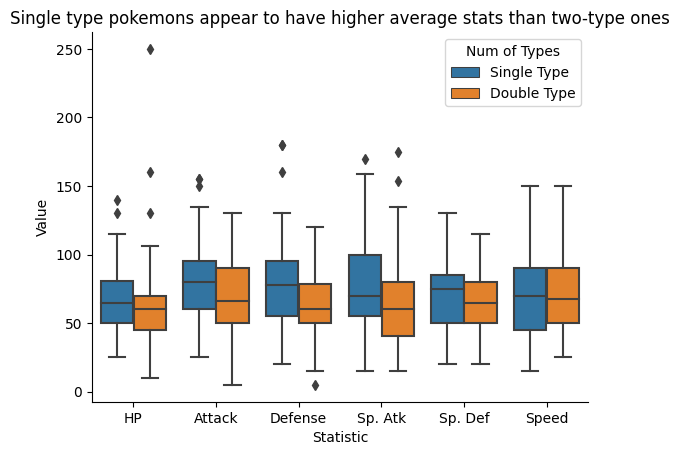

In [37]:
# I can do this with polars but will showcase transforming into pandas in case your plotting library is better suited for pandas df, for example with seaborn. 

# For a polars df to pandas you need to install dependencies. 
# This is done by pip install polars["all"]

pandas_df = (
    stats_by_num_types
    # Transform the data frame to a long form for easier integration with seaborn. 
    .melt(id_vars = "Num of Types",
          value_vars = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"],
          variable_name = "Statistic",
          value_name = "Value",)
    .to_pandas()
)

sns.boxplot(data=pandas_df, y="Value", x="Statistic", hue="Num of Types", orient="v")
plt.title("Single type pokemons appear to have higher average stats than two-type ones")
sns.despine()

print("Confirm df is type pandas.DataFrame: " + str(type(pandas_df)))
# For easier integration with seaborn, need to make the data long

In [57]:
# Check if statistically significant

for stat in ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]:
    g1 = pandas_df[(pandas_df["Num of Types"] == "Single Type") & (pandas_df["Statistic"] == stat)]["Value"]
    
    g2 = pandas_df[(pandas_df["Num of Types"] == "Double Type") & (pandas_df["Statistic"] == stat)]["Value"]
    
    t_statistic, p_value = ttest_ind(g1, g2, alternative="greater")

    if p_value <= 0.05:
        print(f"Single-type pokemons have higher {stat} on average compared to double-type pokemons")
    else:
        print(f"Single-type pokemons have the same {stat} on average compared to double-type pokemons")

Single-type pokemons have the same HP on average compared to double-type pokemons
Single-type pokemons have higher Attack on average compared to double-type pokemons
Single-type pokemons have higher Defense on average compared to double-type pokemons
Single-type pokemons have higher Sp. Atk on average compared to double-type pokemons
Single-type pokemons have the same Sp. Def on average compared to double-type pokemons
Single-type pokemons have the same Speed on average compared to double-type pokemons
